In [1]:
import numpy as np
import numpy.linalg as la
import firedrake.mesh as fd_mesh
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla

from firedrake import *



firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
!python3 -c "import sys; print(sys.executable)"

/Users/nnytko2/.pyenv/versions/3.10.6/bin/python3


In [3]:
# this cell was partially borrowed from CS555-Sp23
import meshpy.triangle as triangle

def round_trip_connect(start, end):
    return [(i, i+1) for i in range(start, end)] + [(end, start)]

def make_unstruct_mesh():

    points = [(0, 0), 
              (1,0),
              (1, 1),
              (0, 1)]
        
    facets = round_trip_connect(0, len(points)-1)
    facet_markers = [3,2,4,1]
    
    def needs_refinement(vertices, area):
        bary = np.sum(np.array(vertices), axis=0)/3
        max_area = 0.01
        return bool(area > max_area)

    info = triangle.MeshInfo()
    info.set_points(points)
    info.set_facets(facets, facet_markers=facet_markers)

    built_mesh = triangle.build(info, refinement_func=needs_refinement)
    from pyop2.mpi import dup_comm
    
    comm = dup_comm(COMM_WORLD)
    plex = fd_mesh._from_cell_list(
        2, np.array(built_mesh.elements), np.array(built_mesh.points), comm)

    import firedrake.cython.dmcommon as dmcommon

    v_start, v_end = plex.getDepthStratum(0)   # vertices
    for facet, fmarker in zip(built_mesh.facets, built_mesh.facet_markers):
        vertices = [fvert + v_start for fvert in facet]
        join = plex.getJoin(vertices)
        plex.setLabelValue(dmcommon.FACE_SETS_LABEL, join[0], fmarker)

    return Mesh(plex)
    

def get_coord(mesh, element='CG', order=1):
    V = VectorFunctionSpace(mesh, element, order)
    return interpolate(SpatialCoordinate(mesh), V).dat.data_ro.copy()




In [4]:
class OperatorStruct:
    
    mesh = None
    V    = None 
    coord= None 
    bc_nodes= None # boundary nodes
    

    def __init__(self, mesh, element='CG', order=1):
        
        self.element = element
        self.order = order
        self.mesh  = mesh
        self.V     = FunctionSpace(mesh, element, order)
        
        self.setup_coord()
        self.setup_bc_nodes()
        self.setup_poisson()
        
    def setup_coord(self):
        V = VectorFunctionSpace(self.mesh, self.element, self.order)
        self.coord = interpolate(SpatialCoordinate(self.mesh), V).dat.data_ro.copy()
        
    def setup_bc_nodes(self):  
        bc = DirichletBC(self.V, Constant(0.0), self.mesh.exterior_facets.unique_markers)
        self.bc_nodes = np.array(bc.nodes)
        self.bc_mask  = np.zeros((self.coord.shape[0],), dtype=bool)
        self.bc_mask[self.bc_nodes] = 1
        
        
    def setup_poisson(self):
        u = TrialFunction(self.V)
        v = TestFunction(self.V)

        a   = inner(grad(u), grad(v)) * dx
        bcs = [DirichletBC(self.V, Constant(0.0), self.mesh.exterior_facets.unique_markers)]   
        A   = assemble(a, bcs=bcs, mat_type='aij')
        self.A = sp.csr_matrix((A.petscmat.getValuesCSR())[::-1])
        

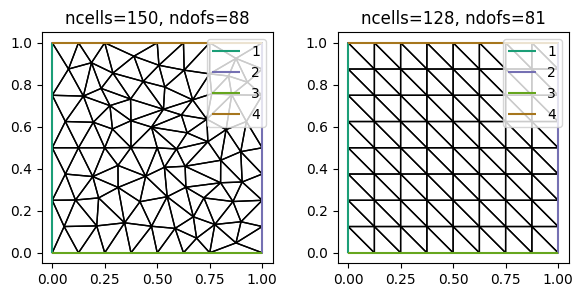

In [5]:


Ou      = OperatorStruct(make_unstruct_mesh())
ndofs_u = int(np.sqrt(Ou.coord.shape[0]))
NEx     = ndofs_u-1
Os      = OperatorStruct(UnitSquareMesh(NEx, NEx))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))


for ax, O in zip(axes, [Ou, Os]):
    triplot(O.mesh, axes=ax)
    ax.set_aspect("equal")
    ax.legend()
    
    ncells = O.mesh.num_cells()    
    ax.set_title(f'ncells={ncells}, ndofs={O.coord.shape[0]}')

plt.show()

# triplot(Ou.mesh)
# plt.scatter(Ou.coord[:,0], Ou.coord[:,1])
# plt.scatter(Ou.coord[Ou.bc_nodes,0], Ou.coord[Ou.bc_nodes,1])
# plt.scatter(Ou.coord[Ou.bc_mask,0], Ou.coord[Ou.bc_mask,1], marker='x', color='r', s=30)
# plt.axis('equal')


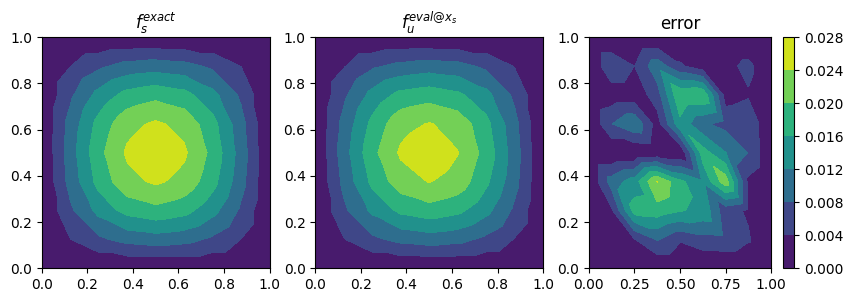

In [6]:

# expected values on unstructured grid
fu_exact = Function(Ou.V)
x        = SpatialCoordinate(Ou.mesh)
fu_exact.interpolate(sin(x[0]*np.pi)*sin(x[1]*np.pi))
# expected values on structured grid
fs_exact = Function(Os.V)
x        = SpatialCoordinate(Os.mesh)
fs_exact.interpolate(sin(x[0]*np.pi)*sin(x[1]*np.pi))
fs_exact.dat.data[Os.bc_mask] = 0


# fu evaliuated at x_s (structured nodes) 
fu_eval_at_xu = Function(Os.V)
fu_eval_at_xu.dat.data[:] = 0
x_s = Os.coord[~Os.bc_mask] # fu_exact.at(.) fails on boundary nodes so we leave the out
fu_eval_at_xu.dat.data[~Os.bc_mask] = np.array(fu_exact.at(x_s))



fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

axs[0].set_title('$f_s^{exact}$')
tricontourf(fs_exact, axes=axs[0]);
axs[1].set_title('$f_u^{eval@x_s}$')
tricontourf(fu_eval_at_xu, axes=axs[1])
axs[2].set_title('error')
error = Function(Os.V)
error.dat.data[:] = np.abs(fs_exact.dat.data-fu_eval_at_xu.dat.data)
l = tricontourf(error, axes=axs[2])
plt.colorbar(l)




/Users/nnytko2/Desktop/firedrake/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|                                                  | 0/4096 [00:00<?, ?it/s]/Users/nnytko2/Desktop/firedrake/lib/python3.10/site-packages/opensimplex/internals.py:35: RuntimeWarning: overflow encountered in scalar multiply
  seed = _overflow(seed * 6364136223846793005 + 1442695040888963407)
/Users/nnytko2/Desktop/firedrake/lib/python3.10/site-packages/opensimplex/internals.py:35: RuntimeWarning: overflow encountered in scalar add
  seed = _overflow(seed * 6364136223846793005 + 1442695040888963407)
100%|██████████████████████████████████████| 4096/4096 [00:07<00:00, 556.09it/s]


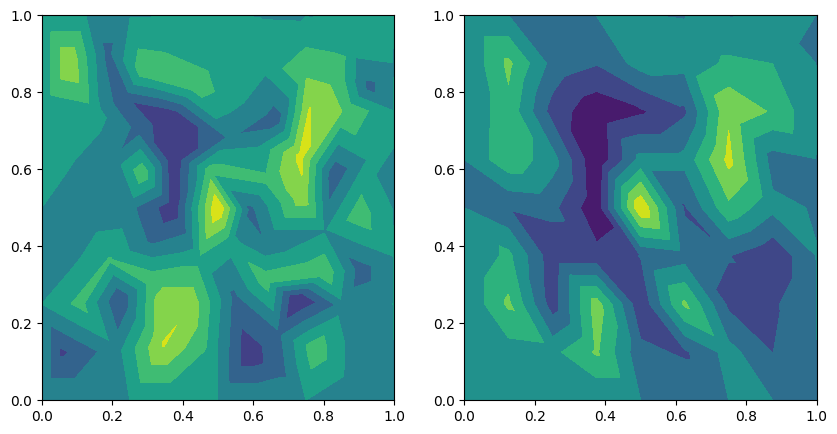

In [7]:
from tqdm import tqdm
from tqdm.contrib import tzip
import opensimplex

fs = []
fu = []

n_f = 4096

X_scale = np.random.randn(n_f, 2) * 10.
seeds = np.random.randint(0, np.iinfo(np.int64).max, n_f)

for i in tqdm(range(4096)):
    seed = seeds[i]
    x_scale, y_scale = X_scale[i]
    
    # We'll use opensimplex to generate random noise at the gridpoints
    
    def opensimplex_fun(X):
        opensimplex.seed(seed)
        x, y = X.T
        bdy_mask = np.sin(x*np.pi)**0.1 * np.sin(y * np.pi) ** 0.1
        noise = np.array([opensimplex.noise2(_x * x_scale, _y * y_scale) for (_x, _y) in zip(x, y)])
        return noise * bdy_mask
    
    fu_exact = Function(Ou.V)
    fu_exact.dat.data[:] = opensimplex_fun(Ou.coord)
    fu.append(np.array(fu_exact.dat.data).copy())
    
    fs_exact = Function(Os.V)
    fs_exact.dat.data[:] = opensimplex_fun(Os.coord)
    fs.append(np.array(fs_exact.dat.data).copy())
    
    if i == 0:
        # plot first function
        fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        tricontourf(fu_exact, axes=ax0)
        tricontourf(fs_exact, axes=ax1)

Optimization problem: find $\arg\min_{P} \ell$, for
$$\ell = \sum_{i=1}^{N_f} \| (f_i)_u^{x_s} - P^T f_u \| + \alpha\sum_{i}\big\|Pe_i\big\|_1^2 + \beta\big\| \text{vec}\big( P^T A_u P \odot (1-\text{mask}(A_s)) \big) \big\|_1^2,$$
where the first term is interpolation loss over all the functions, second term is penalty for nonzeros of columns of P ($e_i$ is i'th elementary vec), and the last term is penalty for nonzero terms in $P^T A_u P$ that do not exist in $A_s$.

In [8]:
# you can use this to install torch if you don't have it
!pip3 install torch torchvision torchaudio


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


0 3095701760.0
1000 42425964.0
2000 15946674.0
3000 8904103.0
4000 5807405.5
5000 4182221.0
6000 3208896.5
7000 2553750.75
8000 2101342.5
9000 1775766.5
10000 1531361.125
11000 1338469.25
12000 1181986.875
13000 1053771.25
14000 943433.625
15000 850577.0625
16000 773792.375
17000 707346.4375
18000 651530.8125
19000 602186.0625
20000 558976.0625
21000 521496.5
22000 487901.9375
23000 458053.625
24000 431685.625
25000 407547.28125
26000 384978.75
27000 364481.78125
28000 345424.96875
29000 327859.1875
30000 311312.65625
31000 296188.71875
32000 281939.03125
33000 269130.96875
34000 257390.90625
35000 246344.234375
36000 236064.609375
37000 226375.703125
38000 217262.96875
39000 208853.9375
40000 200812.4375
41000 193431.328125
42000 186448.03125
43000 179568.671875
44000 173439.40625
45000 167550.6875
46000 162119.765625
47000 156896.140625
48000 152022.25
49000 147327.890625
50000 142995.109375
51000 138966.546875
52000 135101.484375
53000 131330.53125
54000 127866.484375
55000 124398.0

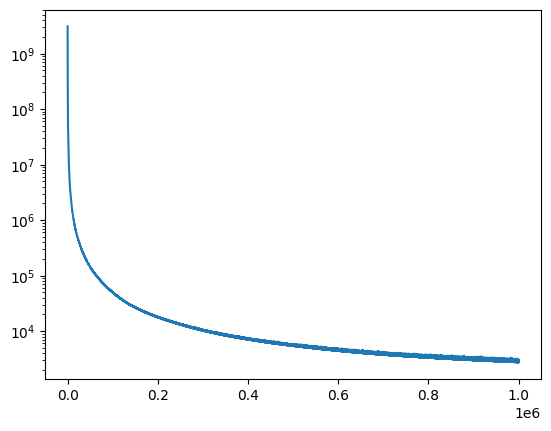

In [9]:
import torch
import torch.optim
import torch.linalg as tla

device = torch.device('cpu')
n_u = Ou.coord.shape[0]
n_s = Os.coord.shape[0]

P = torch.ones((n_s, n_u), device=device, requires_grad=True) # (this is actually transpose of P as defined above. woops)
alpha = torch.tensor(0.05, requires_grad=False)
beta = torch.tensor(0.02, requires_grad=False)

struct_A = Os.A
sparsity_mask = torch.tensor(sp.csr_matrix((np.ones_like(struct_A.data), struct_A.indices, struct_A.indptr), struct_A.shape).todense()).float()
uA_T = torch.tensor(Ou.A.todense()).float()

dirichlet_mask = torch.tensor(np.array(Os.A.diagonal() == 1.))
dirichlet = dirichlet_mask.float() # Explicitly handle dirichlet nodes

optimizer = torch.optim.Adagrad([P], lr=0.02)

batch_size = 16

lh = []

for i in range(1_000_000):
    optimizer.zero_grad()
    
    loss = 0.
    batch = torch.randperm(n_f)[:batch_size]
    for j in batch:
        fu_T = torch.tensor(fu[j]).float()
        fs_T = torch.tensor(fs[j]).float()
        
        err = P @ fu_T - fs_T
        loss += err @ err / batch_size
        
    # add penalty term on nonzeros in P
    loss += (tla.norm(P, ord=1, dim=1)**2.).sum() * alpha
    
    # penalty term on non-matching nonzeros in P A P^T
    galerkin = P @ uA_T @ P.T
    loss += tla.norm((galerkin - galerkin * sparsity_mask).flatten(), ord=1)**2. * beta
    loss += tla.norm(torch.diagonal(galerkin)[dirichlet_mask] - 1) ** 2. # enforce 1 on dirichlet nodes

    loss.backward()    
    optimizer.step()
    
    lh.append(loss.item())
    if i % 1000 == 0:
        print(i, loss.item())
        
plt.semilogy(lh)

In [10]:
P_np = P.detach().numpy()

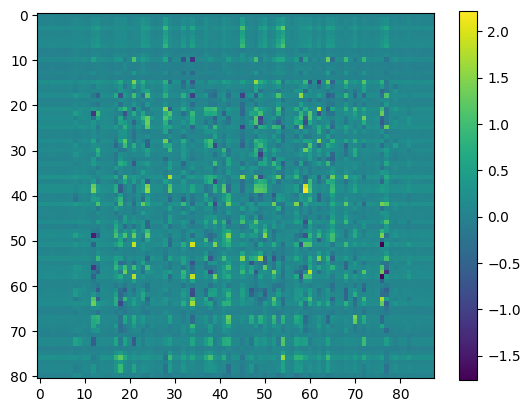

In [11]:
plt.imshow(P_np)
plt.colorbar()

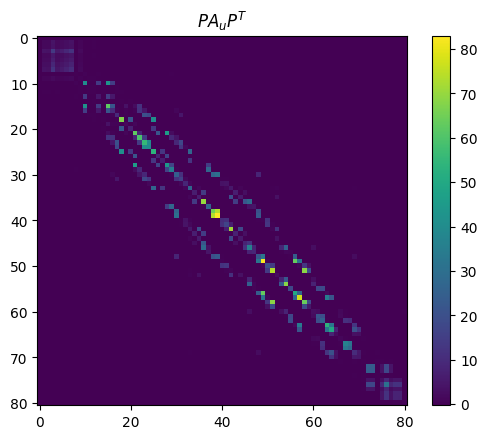

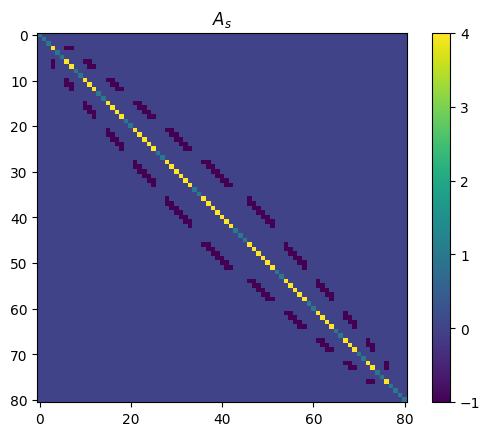

In [12]:
P_m = P_np.copy()

plt.figure()
plt.imshow(P_m @ Ou.A @ P_m.T)
plt.title('$P A_{u} P^T$')
plt.colorbar()

plt.figure()
plt.imshow(Os.A.todense())
plt.title('$A_{s}$')
plt.colorbar()

In [13]:
As = (P_m @ Ou.A @ P_m.T * sparsity_mask.numpy())

In [14]:
print(la.matrix_rank(As), As.shape[1])

81 81


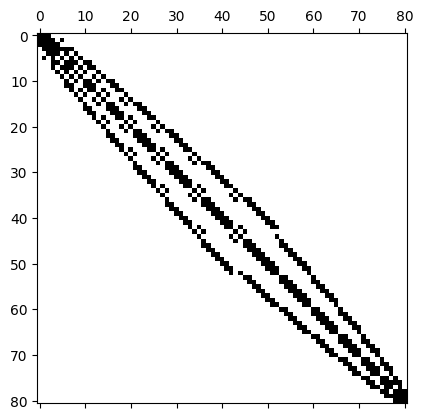

In [15]:
plt.spy(As)

In [16]:
import pyamg

In [17]:
As_ml = pyamg.aggregation.adaptive_sa_solver(As)[0]
print(As_ml)
Au_ml = pyamg.aggregation.adaptive_sa_solver(Ou.A)[0]
print(Au_ml)

MultilevelSolver
Number of Levels:     3
Operator Complexity:  1.189
Grid Complexity:      1.173
Coarse Solver:        'pinv'
  level   unknowns     nonzeros
     0          81          497 [84.09%]
     1          12           90 [15.23%]
     2           2            4 [0.68%]

MultilevelSolver
Number of Levels:     3
Operator Complexity:  1.153
Grid Complexity:      1.159
Coarse Solver:        'pinv'
  level   unknowns     nonzeros
     0          88          562 [86.73%]
     1          12           82 [12.65%]
     2           2            4 [0.62%]



/Users/nnytko2/Desktop/firedrake/lib/python3.10/site-packages/pyamg/aggregation/adaptive.py:222: SparseEfficiencyWarning: Implicit conversion of A to CSR
  warn('Implicit conversion of A to CSR', SparseEfficiencyWarning)


In [18]:
Au = Ou.A
b = np.zeros(Au.shape[0])
x = np.random.randn(Au.shape[0])

In [19]:
res = []
pyamg.krylov.fgmres(Au, b, x, residuals=res)
print(res)

[35.66185824783497, 9.842568859242606, 4.688294205424281, 2.712019123656686, 1.402069564703768, 0.5586601649341268, 0.22910553266813471, 0.12397662708082115, 0.08281656131839425, 0.057894304209005334, 0.03751332124724509, 0.024946221725615097, 0.01950762892392924, 0.014980368247604877, 0.011257341837045368, 0.0068998720736343265, 0.0031590201600784386, 0.0014425794852558562, 0.0006895741972940025, 0.00034062553056692595, 0.0001776839208893149, 0.00010514742483379011, 6.578391393435353e-05, 3.419044537525665e-05, 1.793022193068632e-05, 1.0243750317997178e-05, 4.719929470943259e-06]


In [20]:
res_s = []

def structured_precond(r):
    r_s = P_m @ r
    e_s = As_ml.solve(r_s)
    return P_m.T @ e_s

pyamg.krylov.fgmres(Au, b, x, residuals=res_s, M=spla.LinearOperator(shape=Au.shape, matvec=structured_precond))
print(res_s)

ValueError: array must not contain infs or NaNs

In [ ]:
res_u = []

def unstructured_precond(r):
    return Au_ml.solve(r)

pyamg.krylov.fgmres(Au, b, x, residuals=res_u, M=spla.LinearOperator(shape=Au.shape, matvec=unstructured_precond))
print(res_u)

In [ ]:
plt.semilogy(res, 'o-', label='FGMRES', markersize=3.)
plt.semilogy(res_s, 'o-', label='FGMRES, Structured AMG Precond.', markersize=3.)
plt.semilogy(res_u, 'o-', label='FGMRES, Unstructured AMG Precond.', markersize=3.)
plt.legend()
plt.xlabel('FGMRES Iteration')
plt.ylabel('Residual (2-norm)')
plt.grid()